# Potential from DFT

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from gpaw import GPAW, PW
from gpaw.utilities.ps2ae import PS2AE
from ase.io import read
from ase.lattice.hexagonal import Graphite
import matplotlib.pyplot as plt

from abtem.potentials import Potential
from abtem.waves import PlaneWaves
from abtem.dft import GPAWPotential
from abtem.plot import plot_atoms
from abtem.transform import orthogonalize_atoms

## Creating graphene
We create an orthogonal graphene unit cell.

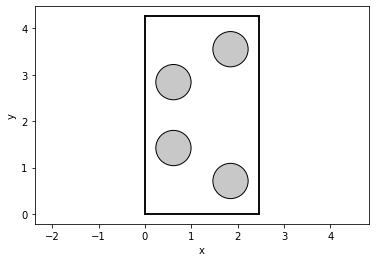

In [2]:
atoms = Graphite(symbol = 'C', latticeconstant = {'a' : 2.46, 'c' : 6.7})
atoms = orthogonalize_atoms(atoms)
atoms = atoms[atoms.positions[:,2] > 1]
atoms.center(vacuum=2, axis=2)
atoms.center()
atoms *= (1,1,1)
atoms.pbc[:] = True

plot_atoms(atoms, scale_atoms=.5)

## Basic DFT calculation with GPAW
GPAW is a density-functional theory (DFT) Python code based on the projector-augmented wave (PAW) method and the atomic simulation environment (ASE). The wave functions can be described with:
* Plane-waves (pw)
* Real-space uniform grids, multigrid methods and the finite-difference approximation (fd)
* Atom-centered basis-functions (lcao)

abTEM needs a converged GPAW calculator object, but otherwise does not have any special requirements. We refer to [GPAW's documentation](https://wiki.fysik.dtu.dk/gpaw/) instructions on how to use it.

Below we do a simple DFT calculation in plane-wave mode with a cutoff energy of 400 eV. We also remember to add extra k-points

using a grid spacing

In [3]:
calc = GPAW(mode=PW(400), h=.1, txt=None, kpts=(4,2,2)) # create a calculator in lcao mode
atoms.set_calculator(calc)
atoms.get_potential_energy()

-36.73305716773301

In [4]:
def riemann_quadrature(num_samples):
    xk = np.linspace(-1., 1., num_samples + 1).astype(np.float32)
    return xk[:-1], xk[1:] - xk[:-1]


def project_spherical_function(f, r, a, b, num_samples=200):
    c = np.reshape(((b - a) / 2.), (-1, 1))
    d = np.reshape(((b + a) / 2.), (-1, 1))
    xk, wk = riemann_quadrature(num_samples)
    xkab = xk * c + d
    wkab = wk * c
    rxy = np.sqrt((r ** 2.).reshape((-1, 1)) + (xkab ** 2.).reshape((1, -1)))
    return np.sum(f(rxy) * wkab.reshape(1, -1), axis=-1)

#@jit(nopython=True, nogil=True)
def get_interpolator(x,y,dydx):
    
    @jit(nopython=True, nogil=True)
    def interpolate_wrapper(x_interp):
        return interpolate_single(x, y, dydx, x_interp)
    
    return interpolate_wrapper

In [64]:
%%timeit
get_interpolator(r,f,dfdr)

51.3 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [65]:
%%timeit
project_tanh_sinh(r_interp, np.array([-1.]), np.array([1]), xk, wk, f)

196 µs ± 3.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


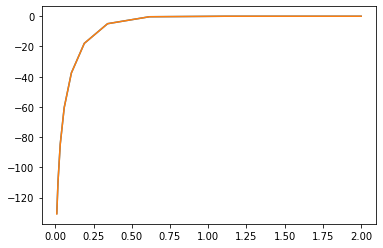

In [54]:
from abtem.dft import get_paw_corrections
from abtem.potentials import tanh_sinh_quadrature
from abtem.parametrizations import project_tanh_sinh
from abtem.interpolation import interpolate_single
from numba import jit

f = get_paw_corrections(calc)[0]['f']
r = get_paw_corrections(calc)[0]['r']
spline = get_paw_corrections(calc)[0]['s']

r_interp = np.geomspace(.01, 2, 10)

vr = project_spherical_function(spline.map, r_interp, -1, 1, num_samples=400)

dfdr = np.diff(f) / np.diff(r)
xk, wk = tanh_sinh_quadrature(200, 4 / 200)

f = get_interpolator(r,f,dfdr)
vr2 = project_tanh_sinh(r_interp, np.array([-1.]), np.array([1]), xk, wk, f)

#def get_interpolator():
    
    

plt.plot(r_interp, vr2[0])
plt.plot(r_interp,vr)


## Creating a DFT potential
Once the DFT calculation is converged it is no more difficult creating a DFT potential than creating it s IAM counterpart. The method for converting a PAW DFT-calculation into an all-electron potential is described by [T Susi et.al.](https://doi.org/10.1016/j.ultramic.2018.11.002)

In [13]:
from ase import units
calc.density.setups[0].xc_correction.rgd.r_g[1] * units.Bohr

0.000707929378680724

In [4]:
potential_dft = GPAWPotential(calc, sampling=.02, interpolation_sampling=.001, quadrature_order=200, sigma=.003).precalculate()

In [5]:
potential_iam = Potential(atoms, sampling=.02, interpolation_sampling=.001, quadrature_order=200).precalculate()

## Comparing the DFT potential to the IAM potential
We show the DFT potential as well as its IAM counterpart. The difference is barely perceptiple by eye since the potential is dominated by the core charge, however showing the relative difference reveals that they may differ by more than 40 % along the C-C bonds.

$$
    \mathrm{Rel. diff.} = \frac{V_{DFT} - V_{IAM}}{V_{IAM} + \epsilon}
$$

It may seem counter-intuitive that the IAM potential is greater along the C-C bonds.  However, this is because the main effect of the electron density is to screen the $1/r$ Coulomb  potential of the cores. Consequently, bonding concentrates the electron density into thenear core regions and between the atoms, reducing the total potential in these regions.

Note that we are subtracting the minimum from each potential for the comparison. A constant factor can be added to a periodic potential without changing the physics.

In [8]:
np.searchsorted([.1,.2,.3,.4],.15)

1

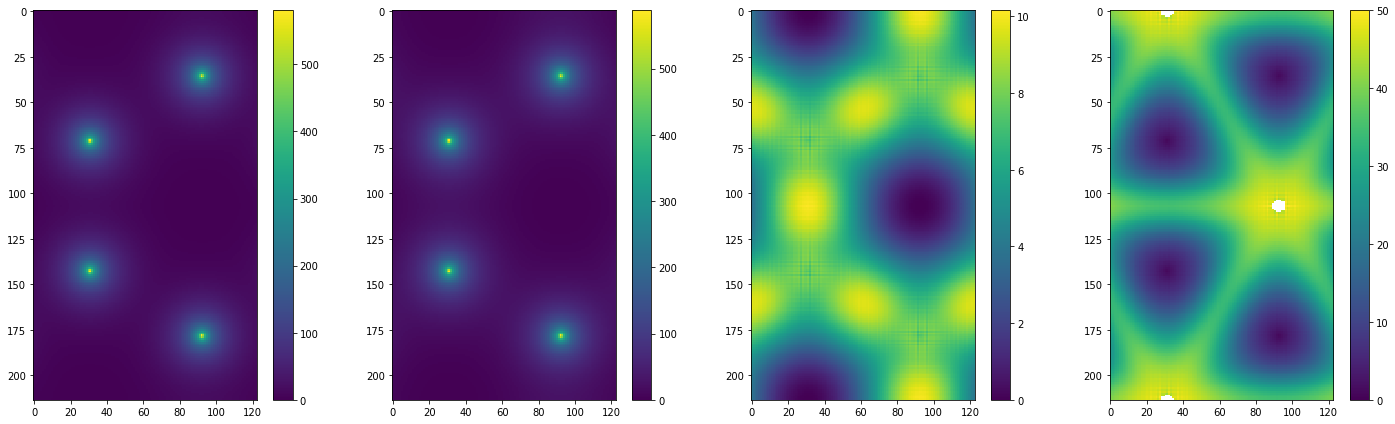

In [6]:
dft_slice = potential_dft.array.sum(0)
dft_slice -= dft_slice.min()
iam_slice = potential_iam.array.sum(0)
iam_slice -= iam_slice.min()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,6))
im1=ax1.imshow(dft_slice.T)
fig.colorbar(im1, ax=ax1)

im2=ax2.imshow(iam_slice.T)
fig.colorbar(im2, ax=ax2)

im3=ax3.imshow(iam_slice.T - dft_slice.T, cmap='viridis', vmin=0)
fig.colorbar(im3, ax=ax3)

rel_diff = (iam_slice - dft_slice) / iam_slice * 100
rel_diff[iam_slice < .1] = np.nan

im4=ax4.imshow(rel_diff.T, cmap='viridis', vmin=0, vmax=50)
fig.colorbar(im4, ax=ax4)

plt.tight_layout()